# Preliminaries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.manifold import TSNE

from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,  davies_bouldin_score
from scipy.spatial.distance import cdist
from kneed import KneeLocator

from tqdm import tqdm

# Data Preprocessing

In [2]:
df = pd.read_csv('C:/Users/Francia/Desktop/data/Capstone/consolidated_csv_01GNPD_U01.csv')
df.head()

,RUN_TIME,MKT_TYPE,REGION_NAME,ZONE_NAME,RESOURCE_NAME,TIME_INTERVAL,START_TIME,END_TIME,MP_NAME,PRICE1,...,RR_BREAK_QUANTITY3,RR_UP3,RR_DOWN3,RR_BREAK_QUANTITY4,RR_UP4,RR_DOWN4,RR_BREAK_QUANTITY5,RR_UP5,RR_DOWN5,Unnamed: 46
0,01/25/2022 12:30:00 PM,RTD,CLUZ,NLUZON,01GNPD_U01,01/25/2022 12:35:00 PM,01/25/2022 12:30:00 PM,01/25/2022 12:35:00 PM,GNPD,-10000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/25/2022 12:35:00 PM,RTD,CLUZ,NLUZON,01GNPD_U01,01/25/2022 12:40:00 PM,01/25/2022 12:35:00 PM,01/25/2022 12:40:00 PM,GNPD,-10000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01/25/2022 12:40:00 PM,RTD,CLUZ,NLUZON,01GNPD_U01,01/25/2022 12:45:00 PM,01/25/2022 12:40:00 PM,01/25/2022 12:45:00 PM,GNPD,-10000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/25/2022 12:45:00 PM,RTD,CLUZ,NLUZON,01GNPD_U01,01/25/2022 12:50:00 PM,01/25/2022 12:45:00 PM,01/25/2022 12:50:00 PM,GNPD,-10000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/25/2022 12:50:00 PM,RTD,CLUZ,NLUZON,01GNPD_U01,01/25/2022 12:55:00 PM,01/25/2022 12:50:00 PM,01/25/2022 12:55:00 PM,GNPD,-10000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dropping of columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155550 entries, 0 to 155549
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   RUN_TIME            155550 non-null  object 
 1   MKT_TYPE            155550 non-null  object 
 2   REGION_NAME         155550 non-null  object 
 3   ZONE_NAME           155550 non-null  object 
 4   RESOURCE_NAME       155550 non-null  object 
 5   TIME_INTERVAL       155550 non-null  object 
 6   START_TIME          155550 non-null  object 
 7   END_TIME            155550 non-null  object 
 8   MP_NAME             153219 non-null  object 
 9   PRICE1              155550 non-null  float64
 10  QUANTITY1           155550 non-null  float64
 11  PRICE2              155550 non-null  float64
 12  QUANTITY2           155550 non-null  float64
 13  PRICE3              149220 non-null  float64
 14  QUANTITY3           149220 non-null  float64
 15  PRICE4              93336 non-null

In [4]:
# Define the columns containing price-quantity pairs and timestamps
price_columns = [f'PRICE{i}' for i in range(1, 12)]
quantity_columns = [f'QUANTITY{i}' for i in range(1, 12)]

# Corrected line with tuple comprehension
selected_columns = ['RUN_TIME'] + [price for price in price_columns] + [quantity for quantity in quantity_columns]

In [5]:
# Apply the selection to the filtered DataFrame
result_df = df[selected_columns]
result_df

,RUN_TIME,PRICE1,PRICE2,PRICE3,PRICE4,PRICE5,PRICE6,PRICE7,PRICE8,PRICE9,...,QUANTITY2,QUANTITY3,QUANTITY4,QUANTITY5,QUANTITY6,QUANTITY7,QUANTITY8,QUANTITY9,QUANTITY10,QUANTITY11
0,01/25/2022 12:30:00 PM,-10000.0,-10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/25/2022 12:35:00 PM,-10000.0,-10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01/25/2022 12:40:00 PM,-10000.0,-10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/25/2022 12:45:00 PM,-10000.0,-10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/25/2022 12:50:00 PM,-10000.0,-10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155545,09/21/2023 12:05:00 AM,-10000.0,-10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155546,09/21/2023 12:10:00 AM,-10000.0,-10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155547,09/21/2023 12:15:00 AM,-10000.0,-10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155548,09/21/2023 12:20:00 AM,-10000.0,-10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df[selected_columns].describe()

,PRICE1,PRICE2,PRICE3,PRICE4,PRICE5,PRICE6,PRICE7,PRICE8,PRICE9,PRICE10,...,QUANTITY2,QUANTITY3,QUANTITY4,QUANTITY5,QUANTITY6,QUANTITY7,QUANTITY8,QUANTITY9,QUANTITY10,QUANTITY11
count,155550.000000,155550.000000,149220.000000,93336.000000,57595.000000,42926.000000,15348.000000,36.0,0.0,0.0,...,155550.000000,149220.000000,93336.000000,57595.000000,42926.000000,15348.000000,36.0,0.0,0.0,0.0
mean,-9989.714503,-9989.714503,2212.574859,4084.499381,4352.314156,4538.178891,4537.592368,10000.0,NaN,NaN,...,344.017986,526.444273,567.874593,589.856429,643.235312,667.518374,668.0,NaN,NaN,NaN
std,320.537027,320.537027,5957.359539,2885.090724,1389.487542,1483.147134,1208.097411,0.0,NaN,NaN,...,55.820118,126.295372,91.055268,60.687956,32.596756,4.342986,0.0,NaN,NaN,NaN
min,-10000.000000,-10000.000000,-9999.000000,2267.830000,2640.590000,2643.820000,2936.210000,10000.0,NaN,NaN,...,1.000000,325.000000,420.000000,450.000000,550.000000,617.000000,668.0,NaN,NaN,NaN
25%,-10000.000000,-10000.000000,0.000000,2911.960000,3222.760000,3463.390000,3516.490000,10000.0,NaN,NaN,...,334.000000,393.600000,501.000000,501.000000,600.000000,668.000000,668.0,NaN,NaN,NaN
50%,-10000.000000,-10000.000000,0.000000,3168.740000,4027.940000,4098.370000,4098.370000,10000.0,NaN,NaN,...,334.000000,510.000000,600.000000,600.000000,668.000000,668.000000,668.0,NaN,NaN,NaN
75%,-10000.000000,-10000.000000,2827.380000,5095.710000,5418.860000,5509.170000,5509.170000,10000.0,NaN,NaN,...,334.000000,668.000000,668.000000,600.000000,668.000000,668.000000,668.0,NaN,NaN,NaN
max,0.000000,0.000000,28891.000000,28891.000000,28891.000000,28891.000000,28891.000000,10000.0,NaN,NaN,...,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.0,NaN,NaN,NaN


In [7]:
#change Uppercase to lowercase
result_df.columns = result_df.columns.str.lower()

## FFill NaNs with last Price-Quantity Bid

In [8]:
# Forward fill from the first non-null value in each row for the price columns
result_df.loc[:, 'price1':'price11'] = result_df.loc[:, 'price1':'price11'].apply(lambda row: row.ffill(), axis=1)

# Forward fill from the first non-null value in each row for the quantity columns
result_df.loc[:, 'quantity1':'quantity11'] = result_df.loc[:, 'quantity1':'quantity11'].apply(lambda row: row.ffill(), axis=1)

## TAKES 30 SECONDS TO RUN
result_df

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,01/25/2022 12:30:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0
1,01/25/2022 12:35:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0
2,01/25/2022 12:40:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0
3,01/25/2022 12:45:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0
4,01/25/2022 12:50:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155545,09/21/2023 12:05:00 AM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
155546,09/21/2023 12:10:00 AM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
155547,09/21/2023 12:15:00 AM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
155548,09/21/2023 12:20:00 AM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Filter to 2022 data

In [9]:
result_df['run_time'] = result_df['run_time'].astype(str)

C:\Users\Francia\AppData\Local\Temp\ipykernel_24536\2012798107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['run_time'] = result_df['run_time'].astype(str)


In [10]:
df_2022 = result_df[result_df['run_time'].str[6:10]=='2022']
df_2022.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,01/25/2022 12:30:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0
1,01/25/2022 12:35:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0
2,01/25/2022 12:40:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0
3,01/25/2022 12:45:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0
4,01/25/2022 12:50:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0


In [11]:
df_2022.describe()

,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
count,57037.0,57037.0,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,...,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000
mean,-10000.0,-10000.0,1892.193045,3926.450623,3983.292365,4032.257027,4041.470226,4044.343593,4044.343593,4044.343593,...,345.907052,566.132060,592.780069,622.943349,643.802984,651.133612,651.165801,651.165801,651.165801,651.165801
std,0.0,0.0,7553.487850,8069.504171,8118.671435,8170.696600,8177.715017,8179.008267,8179.008267,8179.008267,...,67.662625,121.875352,101.570499,82.683033,71.335231,69.925934,69.921952,69.921952,69.921952,69.921952
min,-10000.0,-10000.0,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-10000.0,-10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,323.000000,455.200000,501.000000,600.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
50%,-10000.0,-10000.0,0.000000,3057.980000,3287.340000,3287.340000,3287.340000,3287.340000,3287.340000,3287.340000,...,334.000000,628.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
75%,-10000.0,-10000.0,0.000000,5348.590000,5375.780000,5397.420000,5397.420000,5397.420000,5397.420000,5397.420000,...,334.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
max,-10000.0,-10000.0,28891.000000,28891.000000,28891.000000,28891.000000,28891.000000,28891.000000,28891.000000,28891.000000,...,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000


## Normalize quantity values

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Extract only the quantity columns for normalization
quantity_columns = [f'quantity{i}' for i in range(1, 12)]

# Flatten the DataFrame and extract only quantity columns
flattened_quantities = df_2022[quantity_columns].values.flatten()

# Reshape the flattened quantities to a column vector
flattened_quantities = flattened_quantities.reshape(-1, 1)

# Use MinMaxScaler on the flattened quantities
scaler = MinMaxScaler()
scaled_quantities = scaler.fit_transform(flattened_quantities)

# Reshape the scaled quantities to match the original DataFrame shape
scaled_quantities = scaled_quantities.reshape(df_2022[quantity_columns].shape)

# Update the DataFrame with the scaled values
df_2022.loc[:, quantity_columns] = scaled_quantities

In [13]:
df_2022.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,01/25/2022 12:30:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725
1,01/25/2022 12:35:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725
2,01/25/2022 12:40:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725
3,01/25/2022 12:45:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725
4,01/25/2022 12:50:00 PM,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,...,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725


In [14]:
df_2022.describe()

,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
count,57037.0,57037.0,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,...,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000,57037.000000
mean,-10000.0,-10000.0,1892.193045,3926.450623,3983.292365,4032.257027,4041.470226,4044.343593,4044.343593,4044.343593,...,0.517825,0.847503,0.887395,0.932550,0.963777,0.974751,0.974799,0.974799,0.974799,0.974799
std,0.0,0.0,7553.487850,8069.504171,8118.671435,8170.696600,8177.715017,8179.008267,8179.008267,8179.008267,...,0.101291,0.182448,0.152052,0.123777,0.106789,0.104680,0.104674,0.104674,0.104674,0.104674
min,-10000.0,-10000.0,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,...,0.001497,0.001497,0.001497,0.001497,0.001497,0.001497,0.001497,0.001497,0.001497,0.001497
25%,-10000.0,-10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.483533,0.681437,0.750000,0.898204,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,-10000.0,-10000.0,0.000000,3057.980000,3287.340000,3287.340000,3287.340000,3287.340000,3287.340000,3287.340000,...,0.500000,0.940120,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,-10000.0,-10000.0,0.000000,5348.590000,5375.780000,5397.420000,5397.420000,5397.420000,5397.420000,5397.420000,...,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,-10000.0,-10000.0,28891.000000,28891.000000,28891.000000,28891.000000,28891.000000,28891.000000,28891.000000,28891.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Obtain bidding curve and price series for clustering

In [24]:
# Assuming df is your DataFrame with price-quantity pairs in each row
test_df = df_2022#.iloc[:10000]

# Create empty lists to store data for all stepwise curves
all_quantities = []
all_prices = []
all_intp_quantities = []
all_intp_prices = []

# Iterate through each row
for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc='Processing rows'):
    # Extract price and quantity columns for the current row
    prices = row.filter(like='price')
    quantities = row.filter(like='quantity')

    # Sort data by quantity
    sorted_data = sorted(zip(quantities, prices))
    quantities, prices = zip(*sorted_data)

    # Interpolate prices for regular quantity intervals
    step_fx = interp1d(quantities, prices, kind='previous', fill_value='extrapolate')
    step = df_2022['quantity11'].max() / 10

    # Create a finer quantity range for interpolation
    intp_quantities = np.arange(df_2022['quantity1'].min(), df_2022['quantity11'].max() + 0.1, step)
    
    # Get interpolated prices
    intp_prices = step_fx(intp_quantities)
    
    # Set a condition to handle quantities beyond the maximum in the raw data
    max_quantity_interval = max(quantities)
    intp_prices[intp_quantities > max_quantity_interval] = 33000
    
    # Append data to lists
    all_quantities.append(quantities)
    all_prices.append(prices)
    all_intp_quantities.append(intp_quantities)
    all_intp_prices.append(intp_prices)

Processing rows: 100%|██████████████████████████████████████████████████████████| 57037/57037 [01:13<00:00, 771.20it/s]


In [25]:
# Convert the interpolated prices into price series
price_series = np.array(all_intp_prices)
price_series

array([[-10000., -10000.,  33000., ...,  33000.,  33000.,  33000.],
       [-10000., -10000.,  33000., ...,  33000.,  33000.,  33000.],
       [-10000., -10000.,  33000., ...,  33000.,  33000.,  33000.],
       ...,
       [-10000., -10000., -10000., ..., -10000., -10000., -10000.],
       [-10000., -10000., -10000., ..., -10000., -10000., -10000.],
       [-10000., -10000., -10000., ..., -10000., -10000., -10000.]])

In [26]:
# Export price series to a new graph - remember to change the powerplant name

# Specify the CSV file path
csv_file_path = 'C:/Users/Francia/Desktop/data/Capstone/consolidated_csv_01GNPD_U01_price_series.csv'

# Save the array to a CSV file
np.savetxt(csv_file_path, price_series, delimiter=',')

print(f"Array has been saved to {csv_file_path}")

Array has been saved to C:/Users/Francia/Desktop/data/Capstone/consolidated_csv_01GNPD_U01_price_series.csv


Processing: 100%|████████████████████████████████████████████████████████████████| 10000/10000 [08:04<00:00, 20.64it/s]


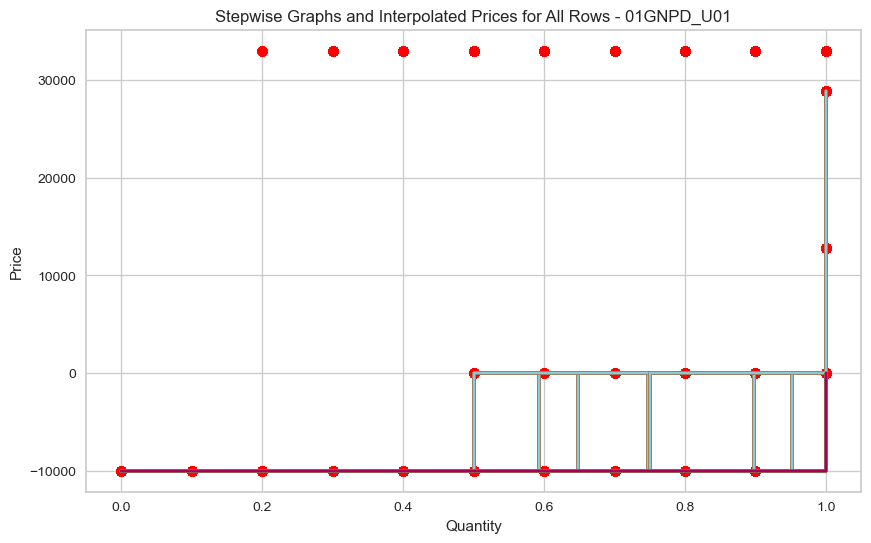

In [22]:
# Plot all stepwise curves on a single graph
# Current graph is only the first 10,000 curves

plt.figure(figsize=(10, 6))

for quantities, prices, intp_quantities, intp_prices in tqdm(zip(all_quantities, all_prices, all_intp_quantities, all_intp_prices), total=len(all_quantities), desc='Processing'):
    plt.step(quantities, prices, where='post')
    plt.scatter(intp_quantities, intp_prices, color='red')

# Customize the plot as needed
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Stepwise Graphs and Interpolated Prices for All Rows - 01GNPD_U01')
plt.show()

# K-Means Clustering

In [27]:
# Create a DataFrame with the original data and cluster labels
price_series_df = pd.DataFrame(price_series, columns=[f'Feature_{i+1}' for i in range(price_series.shape[1])])

In [28]:
price_series_df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11
0,-10000.0,-10000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0
1,-10000.0,-10000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0
2,-10000.0,-10000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0
3,-10000.0,-10000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0
4,-10000.0,-10000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0


## Identify best number of clusters

In [29]:
wcss = {} ## Within-Cluster Sum of Square
ssc = {}
calinski_score = {}
davies_score = {}
K = range(2,16)

for k in tqdm(K, desc='Clustering Progress'):
    #Building and fitting the model
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10).fit(price_series_df)
    kmeans_model.fit(price_series_df)

    wcss[k] = kmeans_model.inertia_ ### sum of squared distances to closest cluster center
    ssc[k] = silhouette_score(price_series_df, kmeans_model.labels_, metric='euclidean')
    davies_score[k] = davies_bouldin_score(price_series_df, kmeans_model.labels_)

Clustering Progress: 100%|█████████████████████████████████████████████████████████████| 14/14 [18:40<00:00, 80.07s/it]


### Visual Method

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

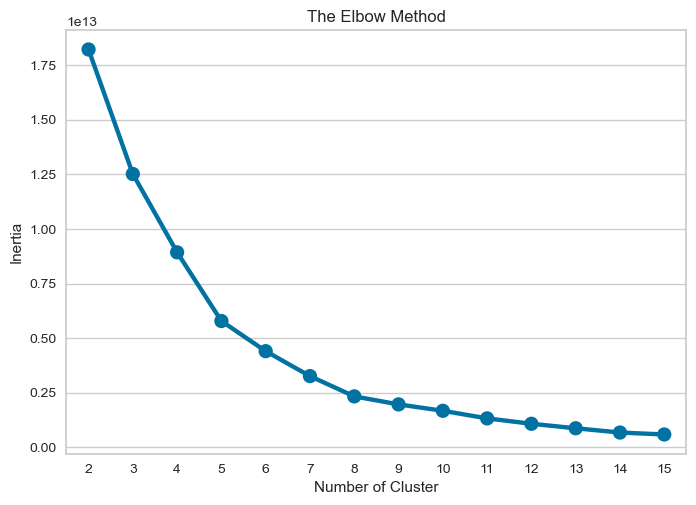

In [30]:
# Check results of elbow method

plt.title('The Elbow Method')
plt.xlabel('Number of Cluster')
plt.ylabel('Inertia')
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.show()

In [31]:
# Locate the knee or elbow
cost_kneed = KneeLocator(x = K , y = list(wcss.values()) , S = 1.0 , curve = 'convex' , direction = 'decreasing' , online = True)
suggested_cluster = cost_kneed.elbow
print('Elbow at k = {} clusters'.format(suggested_cluster))

Elbow at k = 6 clusters


### Mathematical Method

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

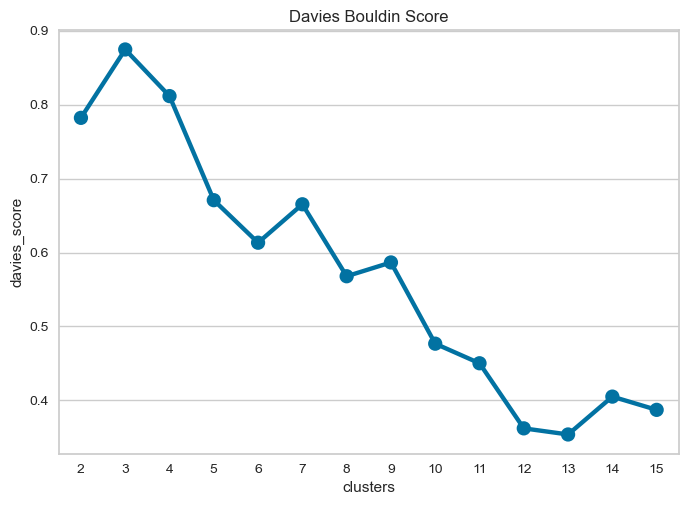

In [32]:
# Create plot for Davies-Bouldin score

plt.title('Davies Bouldin Score')
plt.xlabel('clusters')
plt.ylabel('davies_score')
sns.pointplot(x=list(davies_score.keys()), y=list(davies_score.values()))
plt.show()

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

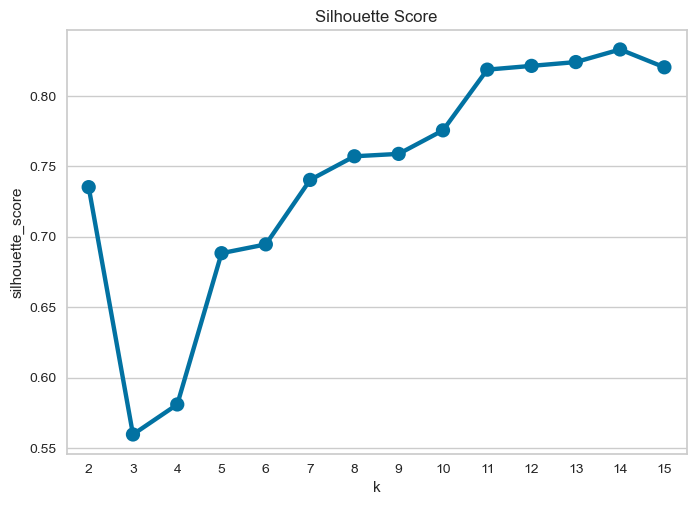

In [33]:
# Create plot for silhouette score

plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('silhouette_score')
sns.pointplot(x=list(ssc.keys()), y=list(ssc.values()))
plt.show()

In [35]:
# Create function for silhouette plot

def silhouette_plot(X , n_list):
    silhouette_scores = []
    for k in tqdm(n_list, desc='Progress'):
        #Instantiate model in k clusters
        model = KMeans(n_clusters = k, random_state=42, n_init=10)
        #Instantiate Visualizer model of with k clusters
        visualizer = SilhouetteVisualizer(model)
        #Fit data to the model
        visualizer.fit(X)
        #Draw data
        visualizer.poof()
        #Append score
        silhouette_scores.append([visualizer.silhouette_score_ , k])
    return silhouette_scores

Progress:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

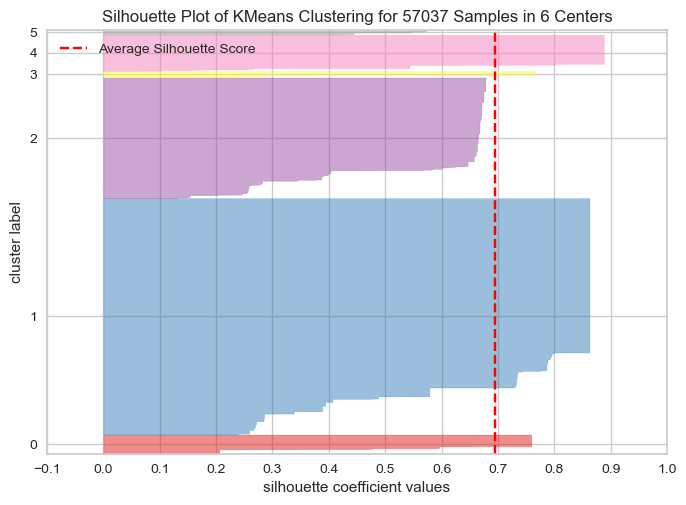

Progress:  33%|████████████████████████▎                                                | 1/3 [02:33<05:07, 153.89s/it]

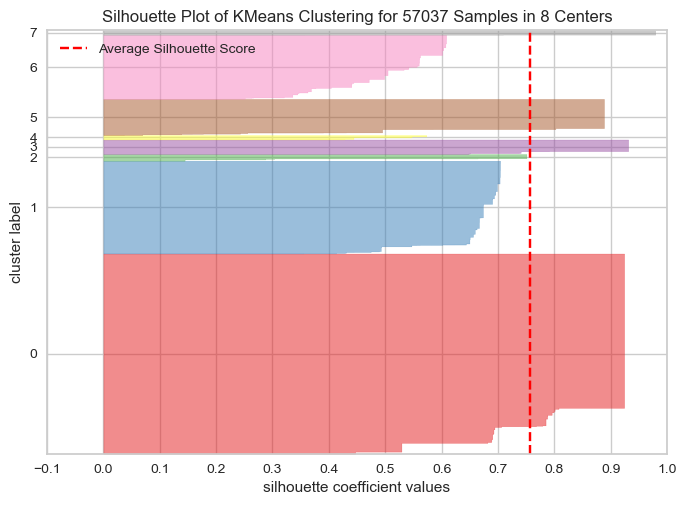

Progress:  67%|████████████████████████████████████████████████▋                        | 2/3 [04:49<02:22, 142.86s/it]

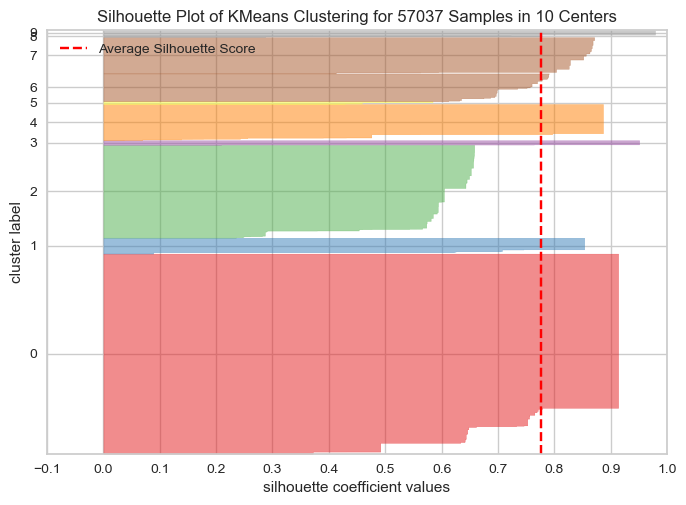

Progress: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [07:03<00:00, 141.23s/it]


[[0.6946186538987431, 6], [0.7571440231535316, 8], [0.7755511989910544, 10]]

In [36]:
# Create silhouette plot

k_cluster_test = [6, 8, 10]

silhouette_plot(price_series_df , k_cluster_test)

## Clustering with chosen k

In [50]:
# Number of clusters (you can choose an appropriate value for your case)
n_clusters = 6

# Initialize K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(price_series)

# Get cluster labels
cluster_labels = kmeans.labels_

# Now, cluster_labels contains the assigned cluster for each row
# You can use these labels for further analysis or visualization


C:\Users\Francia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Snake plot

C:\Users\Francia\AppData\Local\Temp\ipykernel_24536\3315188144.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='variable', y='value', hue='Cluster_Labels', data=df_melted, marker='o', ci=None)
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.t

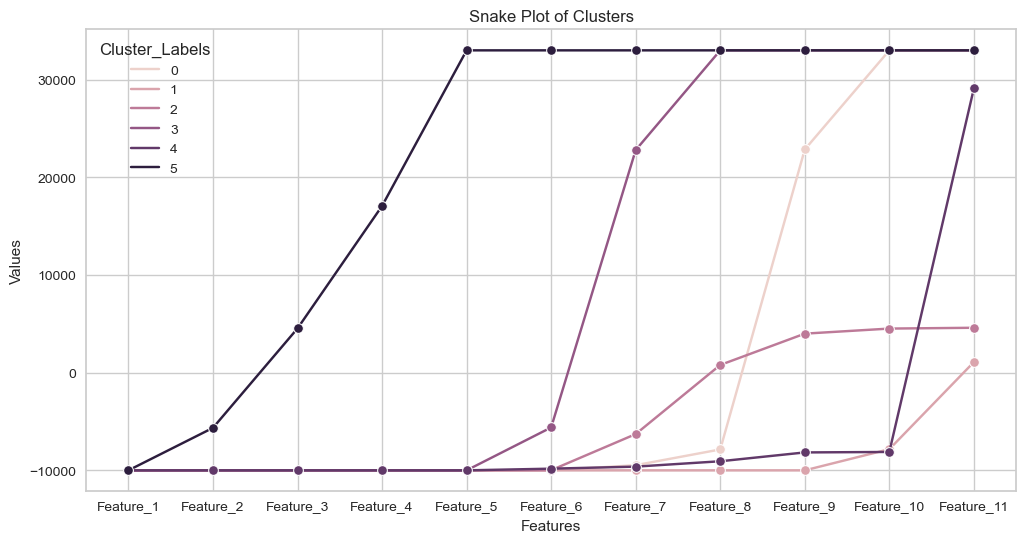

In [51]:
price_series_df['Cluster_Labels'] = cluster_labels

# Melt the DataFrame for the snake plot
df_melted = pd.melt(price_series_df, id_vars='Cluster_Labels', value_vars=price_series_df.columns[:-1])

# Create a snake plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='variable', y='value', hue='Cluster_Labels', data=df_melted, marker='o', ci=None)
plt.title('Snake Plot of Clusters')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

### TSNE graph

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

<Axes: title={'center': 'Flattened Graph of 6 Clusters'}>

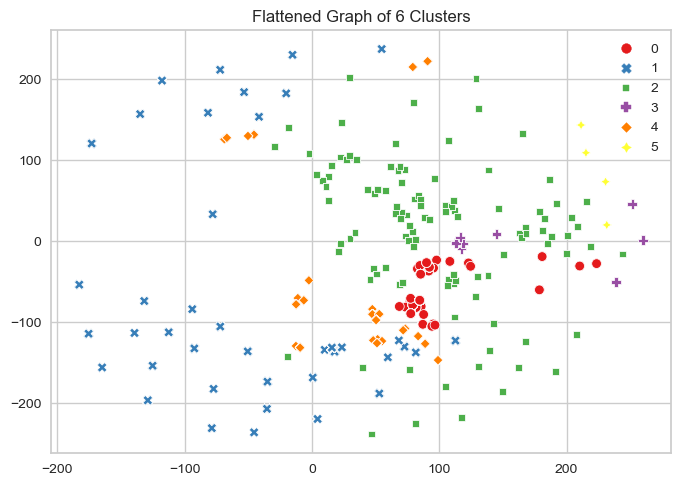

In [52]:
# Initialise TSNE
model = TSNE(random_state=1)
transformed = model.fit_transform(price_series_df)

# Plot t-SNE
plt.title('Flattened Graph of {} Clusters'.format(n_clusters))
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

### Count plot

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

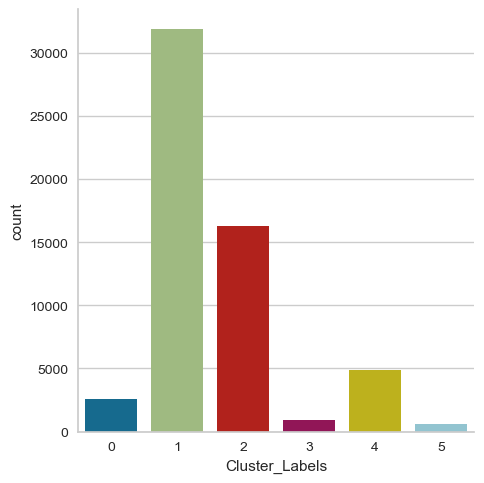

In [53]:
sns.catplot(
    data=price_series_df,
    x="Cluster_Labels",
    kind="count"
  )
plt.show()